In [15]:
from torchvision import transforms
import pytorch_lightning
import torchvision.models as models
import torch.nn as nn
from PIL import Image

In [3]:
IMAGENET_STATS = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
FRAME_SIZE = (int(720/2), int(1280/2))

In [4]:
valid_transforms = transforms.Compose(
      [
        transforms.Resize(FRAME_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(*IMAGENET_STATS)
      ]
    )

In [7]:
class DashcamStopTimeModel(pytorch_lightning.LightningModule):
  def __init__(self):
    super(DashcamStopTimeModel, self).__init__()
    #self.model = models.resnet50(pretrained=True)
    self.model = models.densenet121(pretrained=True)
    print(self.model)
    #self.model.fc = nn.Linear(in_features=2048, out_features=1)
    self.model.classifier = nn.Linear(in_features=1024, out_features=1)
    #freeze_layers(self.model)

  def forward(self, x):
    out = self.model(x)
    return out

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=3e-3)
    return optimizer

  def loss_function(self, logits, labels):
    return F.l1_loss(logits, labels)
    #return F.mse_loss(logits, labels).float()

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    logits = self.forward(x)
    loss = self.loss_function(logits, y)
    self.log('train_loss', loss)
    return loss

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    logits = self.forward(x)
    loss = self.loss_function(logits, y)
    self.log('val_loss', loss)

In [12]:
model = DashcamStopTimeModel.load_from_checkpoint('/home/scott/Documents/fh/project_coursework/lightning_logs/version_3/checkpoints/epoch=232-step=86676.ckpt')

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [17]:
def predict(image_filename):
    image = Image.open(image_filename)
    image_data = valid_transforms(image)

    # Pass the input clip through the model
    preds_pre_act = model(image_data[None, ...])
    print(preds_pre_act)

In [31]:
import matplotlib.pyplot as plt
import matplotlib
def show_img(im, ax=None, figsize=(8,8), bgr=True):
  '''Function taken from lecture material. Added in support for showing RGB images in addition to BGR, set the bgr parameter to be False (defaults to True) to show a RGB image'''
  if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
  if len(im.shape)==2: im = numpy.tile(im[:,:,None], 3)
  show_im = im
  ax.imshow(im[:,:,::-1]);
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  return ax

In [22]:
predict('/mnt/ssd/scott/temp/203aae76-2cbf0b8a.mov/19.jpeg')

tensor([[6978.7397]], grad_fn=<AddmmBackward0>)


(720, 1280, 3)
(720, 1280, 3)
[[[ 90  21   7]
  [ 84  34  10]
  [ 89  44  13]
  ...
  [109  13  17]
  [127  13  12]
  [139  13  10]]

 [[ 87  36  11]
  [ 92  34  12]
  [100  31  14]
  ...
  [ 89  13  19]
  [ 99  13  13]
  [ 97  12   7]]

 [[ 88  34  18]
  [ 96  30  16]
  [104  29  14]
  ...
  [ 76  12  16]
  [ 73  12  14]
  [ 69  11  11]]

 ...

 [[ 89   3   1]
  [ 78   6   4]
  [ 75  11   5]
  ...
  [ 51  10  11]
  [ 53  10  11]
  [ 56  10   9]]

 [[ 99   3   4]
  [ 91   4   8]
  [ 80  10   9]
  ...
  [ 45  11  10]
  [ 47  11  10]
  [ 49  10   8]]

 [[ 89   4   8]
  [ 84   4  13]
  [ 88   8  14]
  ...
  [ 38  11   8]
  [ 38  11   9]
  [ 39  12   9]]]


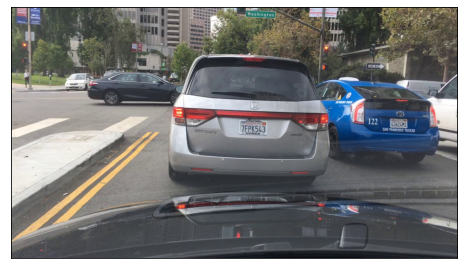

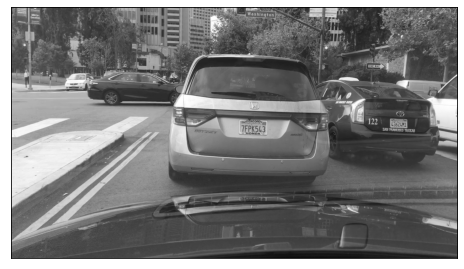

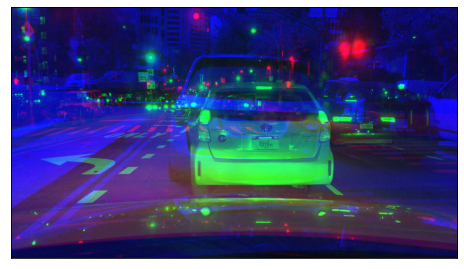

In [40]:
import cv2
import numpy

image1 = cv2.imread('/mnt/ssd/scott/temp/single-image/203aae76-2cbf0b8a.mov/1.jpeg')
image2 = cv2.imread('/mnt/ssd/scott/temp/single-image/0b630871-4bb06884.mov/10.jpeg')
image3 = cv2.imread('/mnt/ssd/scott/temp/single-image/0b22ff59-1594720e.mov/19.jpeg')
show_img(image1)
print(image1.shape)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
show_img(image1)

image_new = numpy.dstack([image1, image2, image3]).astype(numpy.uint8)
print(image_new.shape)
cv2.imwrite('/home/scott/test1.jpeg', image1)
cv2.imwrite('/home/scott/test2.jpeg', image2)
cv2.imwrite('/home/scott/test3.jpeg', image3)
cv2.imwrite('/home/scott/test.jpeg', image_new)

show_img(image_new)
print(image_new)

In [25]:
image